In [26]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
fastf1.Cache.enable_cache("f1_cache")  # cache folder must already exist


In [27]:
def load_monaco_race(year):
    session = fastf1.get_session(year, "Monaco", "R")
    session.load()

    laps = session.laps[[
        "Driver", "DriverNumber", "Team", "LapNumber", "Stint", "Compound",
        "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"
    ]].copy()

    # drop invalid lap entries
    laps = laps.dropna(subset=["LapTime"])

    # convert time to seconds
    for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        laps[f"{col}_s"] = laps[col].dt.total_seconds()

    # keep only numeric lap features
    laps = laps[[
        "Driver", "Team", "LapNumber", "Stint", "Compound",
        "LapTime_s", "Sector1Time_s", "Sector2Time_s", "Sector3Time_s"
    ]]

    laps["Year"] = year

    return laps


In [28]:
data_2022 = load_monaco_race(2022)
data_2023 = load_monaco_race(2023)

#already have 2024, but to keep unified format, load again
data_2024 = load_monaco_race(2024)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Fixed incorrect tyre stint information for driver '11'
core        WARNING 	Fixed incorrect tyre stint information for driver '55'
core        WARNING 	Fixed incorrect tyre stint information for driver '1'
core        WARNING 	Fixed incorrect tyre stint information for driver '16'
core        WARNING 	Fixed incorrect tyre stint information for driver '63'
core        WARNING 	Fixed incorrect tyre stint information for driver '4'
core        WAR

In [29]:
monaco_all = pd.concat([data_2022, data_2023, data_2024], ignore_index=True)
monaco_all.head(), monaco_all.tail()


(  Driver             Team  LapNumber  Stint Compound  LapTime_s  \
 0    VER  Red Bull Racing        1.0    1.0      WET    156.498   
 1    VER  Red Bull Racing        2.0    1.0      WET    142.614   
 2    VER  Red Bull Racing        3.0    1.0      WET    105.603   
 3    VER  Red Bull Racing        4.0    1.0      WET    101.426   
 4    VER  Red Bull Racing        5.0    1.0      WET    100.918   
 
    Sector1Time_s  Sector2Time_s  Sector3Time_s  Year  
 0            NaN         64.033         32.861  2022  
 1         35.053         65.095         42.466  2022  
 2         28.867         48.671         28.065  2022  
 3         27.463         46.871         27.092  2022  
 4         27.345         46.573         27.000  2022  ,
      Driver         Team  LapNumber  Stint Compound  LapTime_s  Sector1Time_s  \
 3886    ZHO  Kick Sauber       72.0    3.0     SOFT     80.585         20.370   
 3887    ZHO  Kick Sauber       73.0    3.0     SOFT     75.233         19.940   
 3888  

In [30]:
print(monaco_all.shape)
print(monaco_all["Year"].value_counts())
print(monaco_all["Driver"].unique())


(3891, 10)
Year
2023    1512
2024    1226
2022    1153
Name: count, dtype: int64
['VER' 'GAS' 'PER' 'ALO' 'LEC' 'STR' 'MAG' 'TSU' 'ALB' 'ZHO' 'RIC' 'OCO'
 'NOR' 'HAM' 'MSC' 'VET' 'SAI' 'LAT' 'RUS' 'BOT' 'SAR' 'DEV' 'HUL' 'PIA']


In [31]:
# aggregate lap features
driver_perf = monaco_all.groupby("Driver").agg({
    "LapTime_s": ["mean", "std"],
    "Sector1Time_s": "mean",
    "Sector2Time_s": "mean",
    "Sector3Time_s": "mean",
    "Year": "nunique"
}).reset_index()

driver_perf.columns = [
    "Driver", "AvgLap", "LapStd", "AvgS1", "AvgS2", "AvgS3", "MonacoRaces"
]

# total avg sectors combined
driver_perf["TotalSector"] = driver_perf["AvgS1"] + driver_perf["AvgS2"] + driver_perf["AvgS3"]

# consistency score (lower = more consistent)
driver_perf["ConsistencyScore"] = driver_perf["LapStd"]

driver_perf.head()


,Driver,AvgLap,LapStd,AvgS1,AvgS2,AvgS3,MonacoRaces,TotalSector,ConsistencyScore
0,ALB,98.344154,170.383565,22.662672,40.116154,23.246195,3,86.025021,170.383565
1,ALO,96.316866,165.278675,22.263103,39.847359,22.878477,3,84.988939,165.278675
2,BOT,96.874250,166.182676,22.395930,40.060810,22.927042,3,85.383782,166.182676
3,DEV,85.575286,9.894230,22.421763,40.492234,22.549584,1,85.463581,9.894230
4,GAS,96.177687,164.242362,22.231182,39.510323,23.019713,3,84.761218,164.242362


In [32]:
constructor_points = {
    "2024": {"McLaren": 282, "Red Bull": 247, "Ferrari": 247, "Mercedes": 86,
             "Aston Martin": 32, "RB": 24, "Haas": 7, "Williams": 4, "Alpine": 5, "Sauber": 0},
    "2023": {"Red Bull": 860, "Mercedes": 409, "Ferrari": 406, "McLaren": 302,
             "Aston Martin": 280, "Alpine": 120, "Williams": 28, "RB": 25, "Haas": 12, "Sauber": 16},
    "2022": {"Red Bull": 759, "Ferrari": 554, "Mercedes": 515, "McLaren": 159,
             "Alpine": 173, "Aston Martin": 55, "AlphaTauri": 35, "Williams": 8, "Haas": 37, "Alfa Romeo": 55}
}


In [33]:
# get latest team per driver (from most recent year in dataset)
latest_team_map = (
    monaco_all.sort_values("Year")
    .drop_duplicates(subset="Driver", keep="last")
    .set_index("Driver")["Team"]
)

# map into driver_perf safely
driver_perf["Team"] = driver_perf["Driver"].map(latest_team_map).fillna("Unknown")


In [34]:
# get latest team per driver (from most recent year in dataset)
latest_team_map = (
    monaco_all.sort_values("Year")
    .drop_duplicates(subset="Driver", keep="last")
    .set_index("Driver")["Team"]
)

# map into driver_perf safely
driver_perf["Team"] = driver_perf["Driver"].map(latest_team_map).fillna("Unknown")

# constructor points mapping function
def get_team_score(team):
    for yr in ["2024","2023","2022"]:
        if team in constructor_points[yr]:
            return constructor_points[yr][team]
    return 0

driver_perf["TeamPoints"] = driver_perf["Team"].apply(get_team_score)
driver_perf["TeamForm"] = driver_perf["TeamPoints"] / driver_perf["TeamPoints"].max()

driver_perf.head()


,Driver,AvgLap,LapStd,AvgS1,AvgS2,AvgS3,MonacoRaces,TotalSector,ConsistencyScore,Team,TeamPoints,TeamForm
0,ALB,98.344154,170.383565,22.662672,40.116154,23.246195,3,86.025021,170.383565,Williams,4,0.014184
1,ALO,96.316866,165.278675,22.263103,39.847359,22.878477,3,84.988939,165.278675,Aston Martin,32,0.113475
2,BOT,96.874250,166.182676,22.395930,40.060810,22.927042,3,85.383782,166.182676,Kick Sauber,0,0.000000
3,DEV,85.575286,9.894230,22.421763,40.492234,22.549584,1,85.463581,9.894230,AlphaTauri,35,0.124113
4,GAS,96.177687,164.242362,22.231182,39.510323,23.019713,3,84.761218,164.242362,Alpine,5,0.017730


In [35]:
# filter slow laps and pit laps
monaco_clean = monaco_all[
    (monaco_all["LapTime_s"] > 60) &
    (monaco_all["LapTime_s"] < 100) &
    (monaco_all["Compound"] != "IN") &
    (monaco_all["Compound"] != "W")
].copy()

# remove pit laps (long sector 1 usually indicates pit entry)
monaco_clean = monaco_clean[monaco_clean["Sector1Time_s"] < monaco_clean["Sector1Time_s"].quantile(0.98)]


In [36]:
def fastest_portion(df, pct=0.20):
    n = max(1, int(len(df) * pct))
    return df.nsmallest(n, "LapTime_s")["LapTime_s"].mean()

driver_year = (
    monaco_clean.groupby(["Year","Driver","Team"])
    .apply(fastest_portion)
    .reset_index(name="Best20pctLap")
)


C:\Users\prana\AppData\Local\Temp\ipykernel_9312\3396774829.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fastest_portion)


In [37]:
# per-driver aggregated metrics
agg = monaco_clean.groupby(["Driver"]).agg(
    LapCount=("LapNumber", "count"),
    Consistency=("LapTime_s", "std"),
    MonacoRaces=("Year", "nunique"),
    AvgS1=("Sector1Time_s", "mean"),
    AvgS2=("Sector2Time_s", "mean"),
    AvgS3=("Sector3Time_s", "mean")
).reset_index()

# compute total sector time
agg["TotalSector"] = agg["AvgS1"] + agg["AvgS2"] + agg["AvgS3"]

# merge into driver_year (so shapes match)
driver_year = driver_year.merge(agg[["Driver","LapCount","Consistency","MonacoRaces","TotalSector"]], 
                                on="Driver", how="left")

# export
driver_year.to_csv("driver_year.csv", index=False)
print("driver_year.csv saved")


driver_year.csv saved


In [38]:
sec = monaco_clean.groupby(["Year","Driver"]).agg(
    AvgS1=("Sector1Time_s","mean"),
    AvgS2=("Sector2Time_s","mean"),
    AvgS3=("Sector3Time_s","mean"),
    Consistency=("LapTime_s","std"),
    LapCount=("LapNumber","count")
).reset_index()

sec["TotalSector"] = sec["AvgS1"] + sec["AvgS2"] + sec["AvgS3"]


In [39]:
driver_year = driver_year.merge(sec, on=["Year","Driver"], how="left")
driver_year["MonacoRaces"] = driver_year.groupby("Driver")["Year"].transform("count")


In [40]:
print(driver_year.columns.tolist())


['Year', 'Driver', 'Team', 'Best20pctLap', 'LapCount_x', 'Consistency_x', 'MonacoRaces', 'TotalSector_x', 'AvgS1', 'AvgS2', 'AvgS3', 'Consistency_y', 'LapCount_y', 'TotalSector_y']


In [41]:
driver_year = driver_year.rename(columns={
    "LapCount_x": "LapCount",
    "Consistency_x": "Consistency",
    "TotalSector_x": "TotalSector"
})

# drop duplicates and temp columns
driver_year = driver_year.drop(columns=[
    "LapCount_y",
    "Consistency_y",
    "TotalSector_y",
    "AvgS1",
    "AvgS2",
    "AvgS3"
], errors="ignore")

print(driver_year.columns.tolist())


['Year', 'Driver', 'Team', 'Best20pctLap', 'LapCount', 'Consistency', 'MonacoRaces', 'TotalSector']


In [42]:
X = driver_year[["TotalSector","Consistency","LapCount","MonacoRaces"]]
y = driver_year["Best20pctLap"]

train = driver_year["Year"].isin([2022,2023])
test = driver_year["Year"].isin([2024])

X_train = X[train]
y_train = y[train]
X_test = X[test]
y_test = y[test]

imp = SimpleImputer(strategy="median")
X_train_i = imp.fit_transform(X_train)
X_test_i = imp.transform(X_test)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train_i,y_train)

y_pred = model.predict(X_test_i)
print("MAE:", mean_absolute_error(y_test,y_pred))


MAE: 0.8166334145457519


In [43]:
driver_year.to_csv("driver_year.csv", index=False)
print("driver_year.csv saved")


driver_year.csv saved


In [44]:
feature_cols = ["TotalSector", "Consistency", "LapCount", "MonacoRaces"]
target_col = "Best20pctLap"


In [45]:
X_all = driver_year[feature_cols]
y_all = driver_year[target_col]

X_all_i = imp.fit_transform(X_all)

final_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

final_model.fit(X_all_i, y_all)
print("Final model trained on all Monaco years (2022–2024)")


Final model trained on all Monaco years (2022–2024)


In [48]:
# split sets once
train_mask = driver_year["Year"].isin([2022, 2023])
test_mask  = driver_year["Year"].isin([2024])

X_train = driver_year.loc[train_mask, feature_cols]
y_train = driver_year.loc[train_mask, target_col]
X_test  = driver_year.loc[test_mask, feature_cols]
y_test  = driver_year.loc[test_mask, target_col]


In [49]:
# MODEL PERFORMANCE EVALUATION
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
# Evaluate on 2024 test data (already split earlier)
y_pred = model.predict(X_test_i)

# ---- Core regression metrics ----
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

print("\n===== MODEL PERFORMANCE: 2024 Monaco Test Data =====")
print(f"Mean Absolute Error (MAE):   {mae:.3f} s")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f} s")
print(f"R² Score: {r2:.3f}")

# ---- Ranking correlation metrics ----
test_results = driver_year.loc[test_mask, ["Driver", target_col]].copy()
test_results["Predicted"] = y_pred

# Rank actual vs predicted (lower = faster)
test_results["ActualRank"] = test_results[target_col].rank()
test_results["PredRank"] = test_results["Predicted"].rank()

spearman_corr, _ = spearmanr(test_results["ActualRank"], test_results["PredRank"])
kendall_corr, _ = kendalltau(test_results["ActualRank"], test_results["PredRank"])

print(f"Spearman Rank Correlation:   {spearman_corr:.3f}")
print(f"Kendall Tau Correlation:     {kendall_corr:.3f}")

# ---- Position accuracy ----
pos_diff = abs(test_results["ActualRank"] - test_results["PredRank"])
within1 = (pos_diff <= 1).mean()
within2 = (pos_diff <= 2).mean()
within3 = (pos_diff <= 3).mean()

print(f"Position accuracy (±1 place): {within1*100:.1f}%")
print(f"Position accuracy (±2 places): {within2*100:.1f}%")
print(f"Position accuracy (±3 places): {within3*100:.1f}%")


===== MODEL PERFORMANCE: 2024 Monaco Test Data =====
Mean Absolute Error (MAE):   0.817 s
Root Mean Squared Error (RMSE): 0.992 s
R² Score: 0.176
Spearman Rank Correlation:   0.574
Kendall Tau Correlation:     0.400
Position accuracy (±1 place): 37.5%
Position accuracy (±2 places): 37.5%
Position accuracy (±3 places): 62.5%


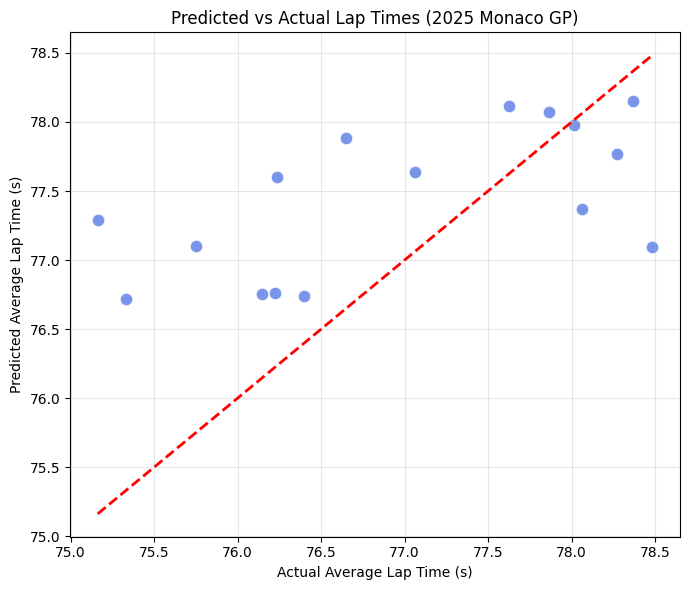

In [57]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, s=80, color="royalblue", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Average Lap Time (s)")
plt.ylabel("Predicted Average Lap Time (s)")
plt.title("Predicted vs Actual Lap Times (2025 Monaco GP)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

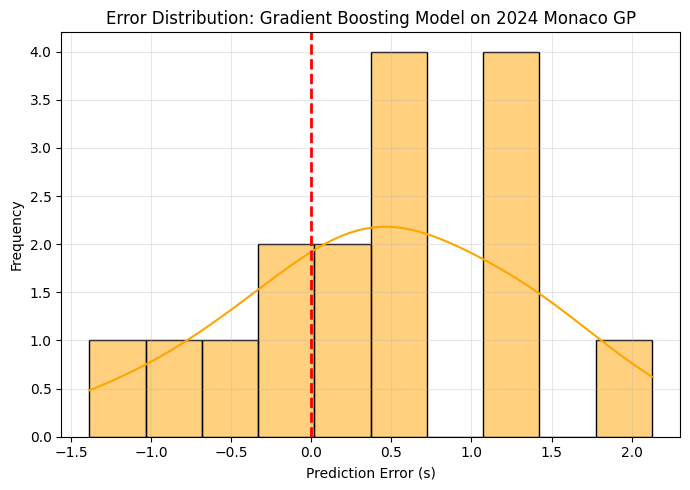

In [56]:
errors = y_pred - y_test

plt.figure(figsize=(7,5))
sns.histplot(errors, bins=10, kde=True, color="orange", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", lw=2)
plt.title("Error Distribution: Gradient Boosting Model on 2024 Monaco GP", fontsize=12)
plt.xlabel("Prediction Error (s)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


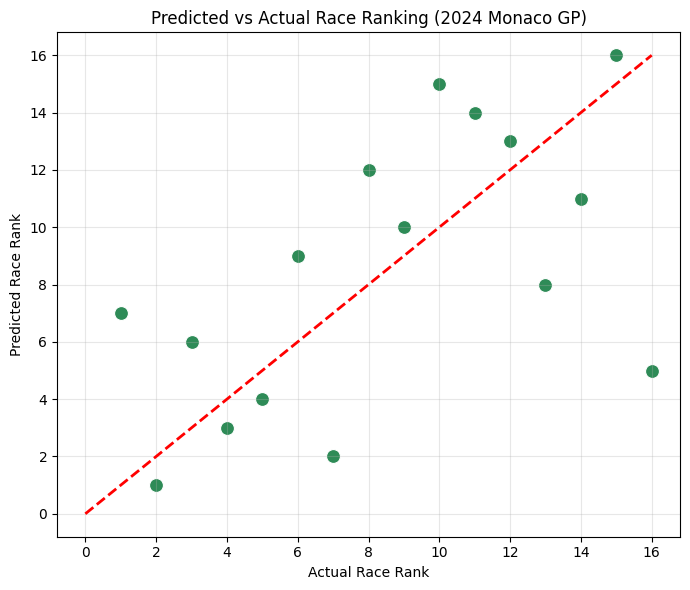

In [54]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=test_results["ActualRank"], y=test_results["PredRank"], s=100, color="seagreen")
plt.plot([0, max(test_results["ActualRank"].max(), test_results["PredRank"].max())],
         [0, max(test_results["ActualRank"].max(), test_results["PredRank"].max())],
         "r--", lw=2)
plt.xlabel("Actual Race Rank")
plt.ylabel("Predicted Race Rank")
plt.title("Predicted vs Actual Race Ranking (2024 Monaco GP)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


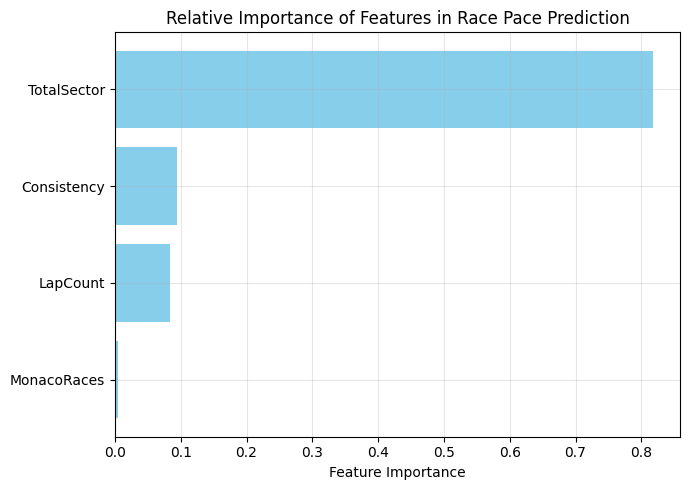

In [55]:
import numpy as np

importances = model.feature_importances_
sorted_idx = np.argsort(importances)
plt.figure(figsize=(7,5))
plt.barh(np.array(feature_cols)[sorted_idx], importances[sorted_idx], color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Relative Importance of Features in Race Pace Prediction")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
import pickle

with open("monaco_model.pkl", "wb") as f:
    pickle.dump((final_model, imp, feature_cols), f)

print("Model saved to monaco_model.pkl")


Model saved to monaco_model.pkl
